# Image modelling

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import *
from scipy.ndimage import shift, zoom
from func_lib import zemax_to_array, get_countrate, rad_to_asec, CCD_output
import imageio

In [2]:
# Telescope values
aperture = 10 # diameter, cm
central_obscuration = 1.75 # diameter, cm
nwavels = 1001
wl_range = [4450, 5450] # Angstroms

In [3]:
# Detector values
fps = 7.5
num_pix = 2000
pix_spacing = 7e-6
fl = 3.85

In [4]:
# Star values
acenA = {"mag":0.01, 
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30}

acenB = {"mag":1.33, 
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37}

In [5]:
# Input the raw the psf from zemax
acenA["psf_raw"], acenA["psf_metadata"] = zemax_to_array('Toliman_on-axis_broadband.txt')
acenB["psf_raw"], acenB["psf_metadata"] = zemax_to_array('Toliman_off-axis_broadband.txt')

# Calculate photon rate per second
acenA["rate/s"] = get_countrate(aperture, central_obscuration, nwavels, wl_range, acenA)
acenB["rate/s"] = get_countrate(aperture, central_obscuration, nwavels, wl_range, acenB)
# acenB["rate/s"] = get_countrate(aperture, central_obscuration, nwavels, wl_range, acenA)

# Caluate photon rate per frame
acenA["rate/frame"] = acenA["rate/s"]/fps
acenB["rate/frame"] = acenB["rate/s"]/fps

# Normalise the zemax psfs to photon count per frame
acenA["psf_norm"] = acenA["rate/frame"] * acenA["psf_raw"] / np.sum(acenA["psf_raw"])
acenB["psf_norm"] = acenB["rate/frame"] * acenB["psf_raw"] / np.sum(acenB["psf_raw"])

### Shift acenB and combine PSF's

In [6]:
acenA["coord"] = SkyCoord("14h39m36.49400s -60d50m02.3737s")
acenB["coord"] = SkyCoord("14h39m35.06311s -60d50m15.0992s")
seperation_asec = acenA["coord"].separation(acenB["coord"]).arcsec

In [7]:
zemax_pixel_size = 1.75e-6
psf_image_size = acenA["psf_norm"].shape[0]

fov_asec = rad_to_asec(psf_image_size * zemax_pixel_size / fl)
fov_per_pix_asec = fov_asec/psf_image_size
pixel_seperation = seperation_asec/fov_per_pix_asec

In [8]:
# Calculate range of pixel shift values
num_positions = 100 # i position per degree
thetas = np.linspace(-np.pi, np.pi, num=num_positions)
r = pixel_seperation

xs = [r*np.cos(theta) for theta in thetas]
ys = [r*np.sin(theta) for theta in thetas]

coords = np.array([(xs[i], ys[i]) for i in range(len(xs))])

In [9]:
# idx = np.random.randint(0, num_positions)
psfs_oversampled = []
for idx in range(num_positions):
    psf_oversampled = shift(acenA["psf_norm"], [0, 0]) + shift(acenB["psf_norm"], [coords[idx][0], coords[idx][1]]) 
    psfs_oversampled.append(psf_oversampled)

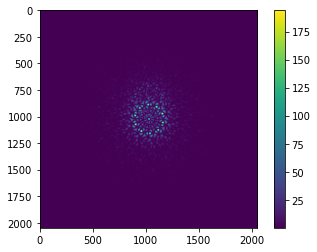

In [10]:
c = psf_oversampled.shape[0]//2
s = 350
# plt.imshow(psf_oversampled[c-s:c+s, c-s:c+s])
plt.imshow(psf_oversampled)
plt.colorbar()
plt.show()

### Interpolate the psf on to the detector

In [11]:
ratio = zemax_pixel_size/pix_spacing

detector_psfs = []
for psf_oversampled in psfs_oversampled:
    detector_psf = zoom(psf_oversampled, ratio)
    detector_psfs.append(detector_psf)

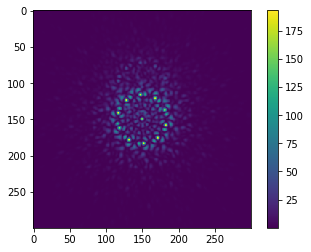

In [12]:
c = detector_psf.shape[0]//2
s = 150
plt.imshow(detector_psf[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

### CCD camera modelling

In [77]:
ims = []
gif_ims = []
gif_ims_noisy = []
for detector_psf in detector_psfs:
    im = np.abs(CCD_output(detector_psf, QE=0.9, read_noise=1.6, dark_current=0.68, fps=fps, gain=1.29, full_well=95e3))
    ims.append(im)
    
    im_scaled = 255*(im/np.max(im))
    gif_im = im_scaled.astype(np.uint8)
    gif_ims.append(gif_im)
    
    im_noisy = (im**0.5)
    im_noisy_scaled = 255*(im_noisy/np.max(im_noisy))
    gif_im_noisy = im_noisy_scaled.astype(np.uint8)
    gif_ims_noisy.append(gif_im_noisy)

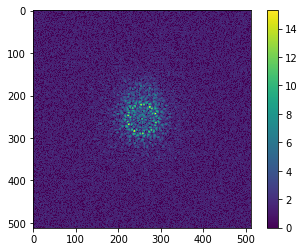

In [78]:
plt.imshow(im_noisy)
plt.colorbar()
plt.show()

In [79]:
imageio.mimsave('normal.gif', gif_ims)
imageio.mimsave('noisy.gif', gif_ims_noisy)